In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


**Import and Analyse the Data**

In [75]:
# Loading the data into a dataframe using sep='\s+'
column_names = ["label"] + [f"feature_{i}" for i in range(1, 9)]
data = pd.read_csv('diabetes_scale.txt', sep='\s+', names=column_names)

# Convert the labels: -1 -> 1 and +1 -> 0, as I found in the original data people 
# without diabetes are 500 labeled as 0 and with diabetes are 268 labeled as 1
data['label'] = data['label'].apply(lambda x: 0 if x == 1 else 1)

data.head()


,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,1,1:-0.294118,2:0.487437,3:0.180328,4:-0.292929,5:-1,6:0.00149028,7:-0.53117,8:-0.0333333
1,0,1:-0.882353,2:-0.145729,3:0.0819672,4:-0.414141,5:-1,6:-0.207153,7:-0.766866,8:-0.666667
2,1,1:-0.0588235,2:0.839196,3:0.0491803,4:-1,5:-1,6:-0.305514,7:-0.492741,8:-0.633333
3,0,1:-0.882353,2:-0.105528,3:0.0819672,4:-0.535354,5:-0.777778,6:-0.162444,7:-0.923997,8:-1
4,1,1:-1,2:0.376884,3:-0.344262,4:-0.292929,5:-0.602837,6:0.28465,7:0.887276,8:-0.6


In [76]:
data.label.value_counts()

label
0    500
1    268
Name: count, dtype: int64

**Data Visualization**

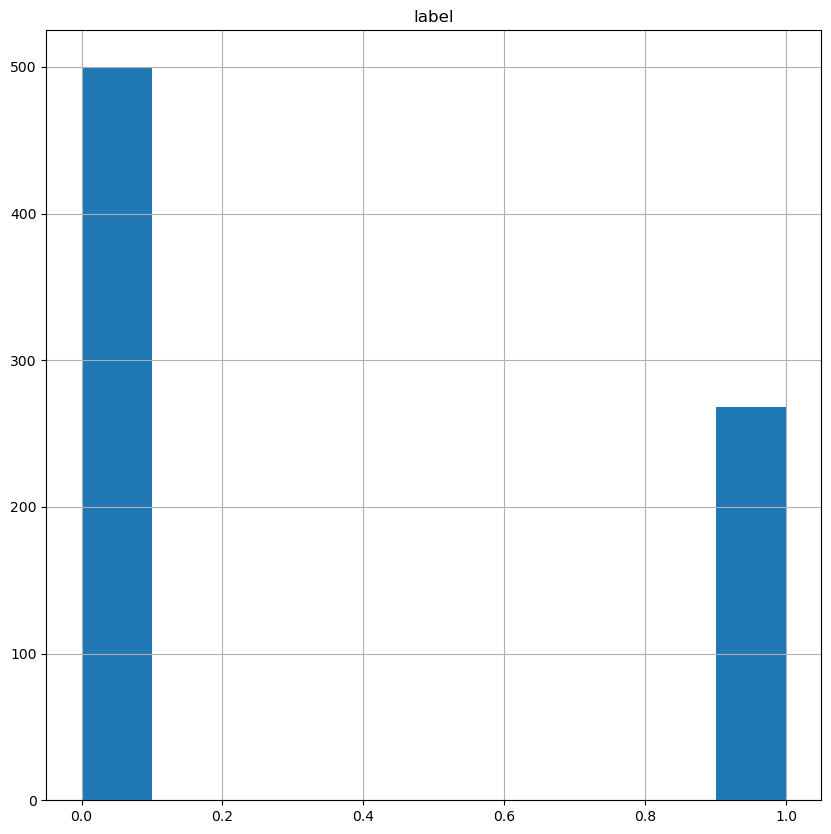

In [78]:
h = data.hist(figsize = (10,10))

In [79]:
# Check for missing values in the dataset
data.replace("?", float("NaN"), inplace=True)  

# Convert features to numeric values by removing the feature index prefix
for col in data.columns[1:]:
    data[col] = data[col].apply(lambda x: float(x.split(":")[1]) if isinstance(x, str) else x)

# Fill missing values with the median of each column
data.fillna(data.median(), inplace=True)
data.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,1,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333
1,0,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667
2,1,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333
3,0,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000
4,1,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000


In [50]:
! pip install imblearn

In [106]:
from imblearn.over_sampling import SMOTE

X = data.drop('label', axis=1)
y = data['label']

# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled features and target into a new dataframe
balanced_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

balanced_data.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report

# Splitting the data (60, 20, 20 Split)
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

perceptron = Perceptron(random_state=42)
perceptron.fit(X_train, y_train)
y_val_pred_baseline = perceptron.predict(X_val)

#Training and Evaluation
perceptron.fit(X_train, y_train)
y_val_pred = perceptron.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print validation accuracy and classification report
val_report = classification_report(y_val, y_val_pred)

print(val_accuracy, val_report)


0.725               precision    recall  f1-score   support

           0       0.77      0.60      0.68        96
           1       0.70      0.84      0.76       104

    accuracy                           0.72       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



**Hyperparameter Optimization**

In [103]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'penalty': [None, 'l2', 'l1'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [2000, 3000, 4000],
    'tol': [1e-3, 1e-4, 1e-5]
}

perceptron = Perceptron(random_state=42)


# Now use best_perceptron to predict and generate confusion matrix
y_val_pred_tuned = best_perceptron.predict(X_val)
# Performing GridSearchCV to find the best parameters
grid_search = GridSearchCV(perceptron, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Training the Perceptron model with the best parameters and Prediction
best_perceptron = grid_search.best_estimator_
y_val_pred = best_perceptron.predict(X_val)

# Evaluating the model
tuned_val_accuracy = accuracy_score(y_val, y_val_pred)
tuned_val_report = classification_report(y_val, y_val_pred)

print(f"Validation Accuracy: {tuned_val_accuracy}")
print(f"Classification Report:\n {tuned_val_report}")


Best parameters found:  {'alpha': 0.01, 'max_iter': 2000, 'penalty': 'l1', 'tol': 0.001}
Validation Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.88      0.75        96
           1       0.83      0.58      0.68       104

    accuracy                           0.72       200
   macro avg       0.74      0.73      0.72       200
weighted avg       0.75      0.72      0.71       200



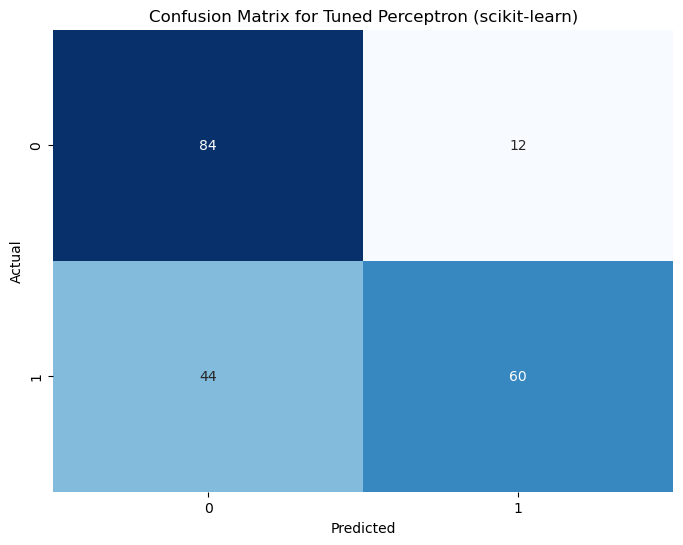

In [104]:

# Predict on the validation set using the tuned Perceptron
y_val_pred_tuned = best_perceptron.predict(X_val)

conf_matrix_tuned = confusion_matrix(y_val, y_val_pred_tuned)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Tuned Perceptron (scikit-learn)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [92]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Building a model using binary cross-entropy loss
model = models.Sequential([
    layers.Dense(1, activation='sigmoid', input_dim=X_train.shape[1])  
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Training and Evaluation
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=250, batch_size=32)
val_loss, val_accuracy = model.evaluate(X_val, y_val)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/250
19/19 [==============================] - 1s 11ms/step - loss: 0.7360 - accuracy: 0.4983 - val_loss: 0.7276 - val_accuracy: 0.5000
Epoch 2/250
19/19 [==============================] - 0s 4ms/step - loss: 0.7257 - accuracy: 0.4983 - val_loss: 0.7172 - val_accuracy: 0.5200
Epoch 3/250
19/19 [==============================] - 0s 4ms/step - loss: 0.7173 - accuracy: 0.5067 - val_loss: 0.7085 - val_accuracy: 0.5250
Epoch 4/250
19/19 [==============================] - 0s 4ms/step - loss: 0.7098 - accuracy: 0.5117 - val_loss: 0.7018 - val_accuracy: 0.5350
Epoch 5/250
19/19 [==============================] - 0s 4ms/step - loss: 0.7040 - accuracy: 0.5150 - val_loss: 0.6957 - val_accuracy: 0.5250
Epoch 6/250
19/19 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.5250 - val_loss: 0.6909 - val_accuracy: 0.5550
Epoch 7/250
19/19 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5333 - val_loss: 0.6866 - val_accuracy: 0.5650
Epoch 8/250


7/7 [==============================] - 0s 3ms/step


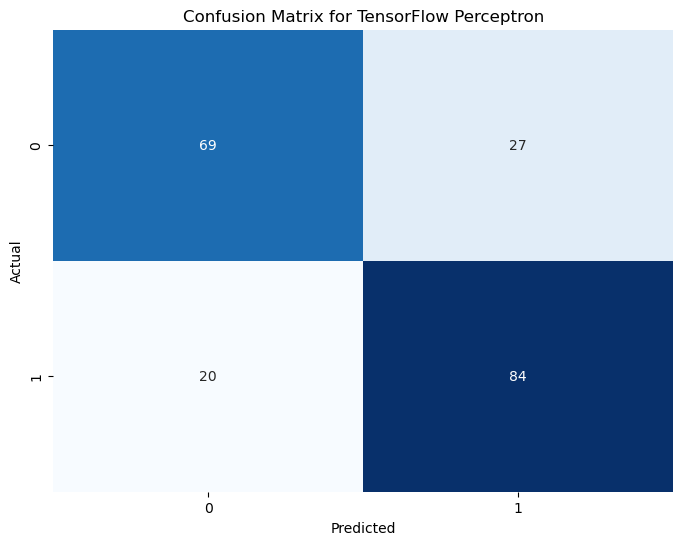

In [93]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting the validation set using the TensorFlow Perceptron
y_val_pred_tf = (model.predict(X_val) > 0.5).astype(int)

conf_matrix = confusion_matrix(y_val, y_val_pred_tf)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for TensorFlow Perceptron')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


***The model built with binary cross entropy does better with 76.5% accuracy than the baseline and the scikit learn perceptron models with 72.5% and 72% Accuracy respectively.***